In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [17]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Load and Prepare Data

In [18]:
# Load your NIFTY50 dataset
df = pd.read_csv('/content/drive/MyDrive/ZIDIO/NIFTY50_all.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Filter for a single stock, e.g., HDFC
data = df[df['Symbol'] == 'HDFC'].copy()

# Remove missing values
data.dropna(inplace=True)

# Detect and remove outliers in 'Close' using IQR
Q1 = data['Close'].quantile(0.25)
Q3 = data['Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['Close'] >= lower_bound) & (data['Close'] <= upper_bound)]


PROPHET MODEL

In [19]:
df_prophet = data[['Date', 'Close']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')
df_prophet.dropna(inplace=True)

In [20]:
model = Prophet()
model.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiknqtm_r/a6u90ybj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiknqtm_r/q9rro1v_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68232', 'data', 'file=/tmp/tmpiknqtm_r/a6u90ybj.json', 'init=/tmp/tmpiknqtm_r/q9rro1v_.json', 'output', 'file=/tmp/tmpiknqtm_r/prophet_model2b_fclps/prophet_model-20250719071816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [21]:
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

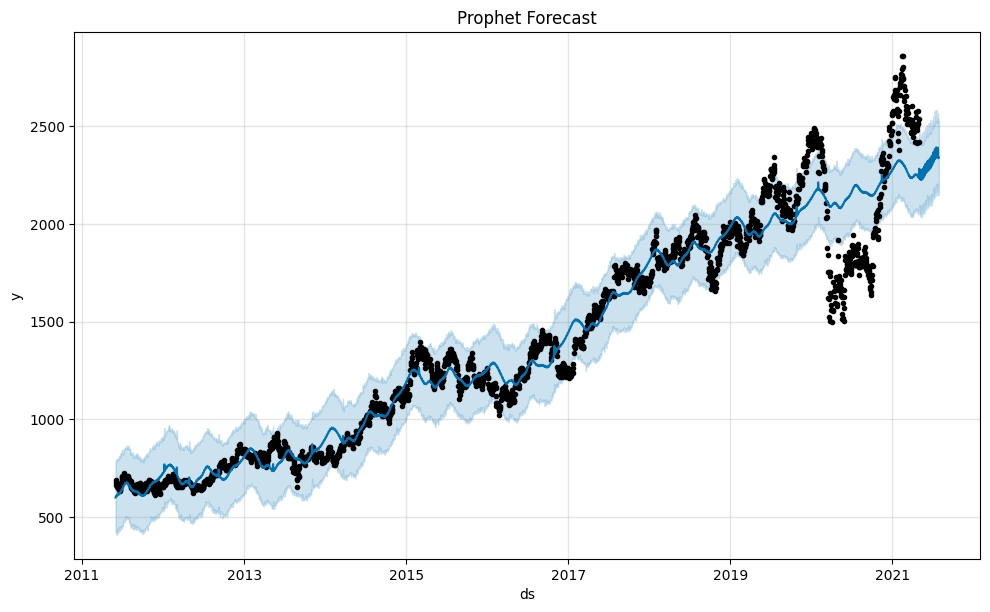

In [22]:
model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

In [23]:
forecast_trimmed = forecast.set_index('ds').loc[df_prophet['ds']]
prophet_rmse = np.sqrt(mean_squared_error(df_prophet['y'], forecast_trimmed['yhat']))
print(f"Prophet RMSE: {prophet_rmse:.2f}")

Prophet RMSE: 144.05


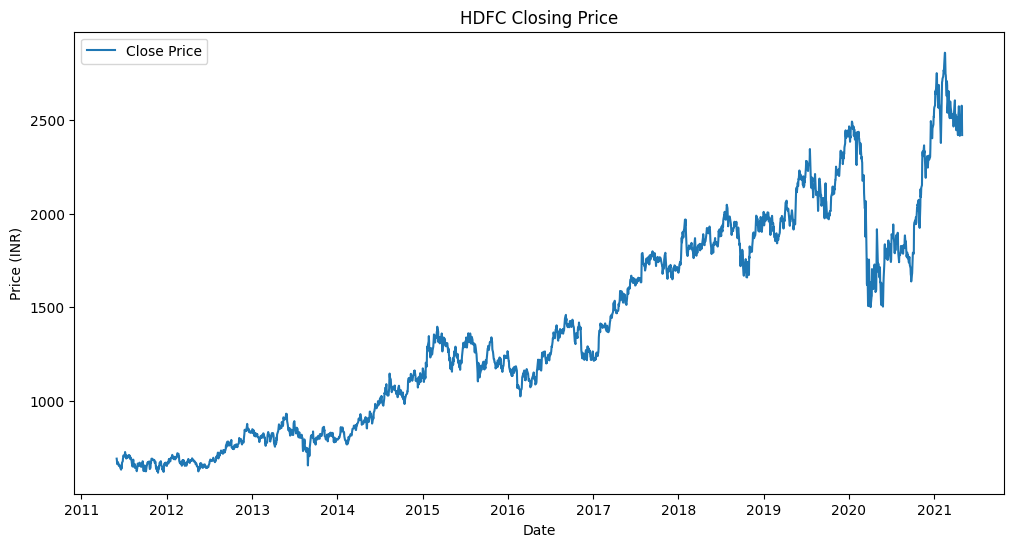

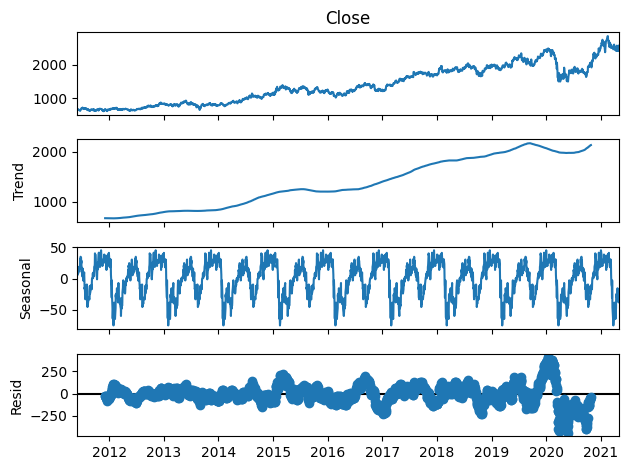

In [24]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.title('HDFC Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

result = seasonal_decompose(data['Close'], model='additive', period=252)
result.plot()
plt.show()

ARIMA MODEL

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1964
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8580.838
Date:                Sat, 19 Jul 2025   AIC                          17173.675
Time:                        07:18:45   BIC                          17207.169
Sample:                             0   HQIC                         17185.985
                               - 1964                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0046      0.018     -0.255      0.799      -0.040       0.031
ar.L2         -0.0466      0.019     -2.432      0.015      -0.084      -0.009
ar.L3         -0.0425      0.018     -2.350      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


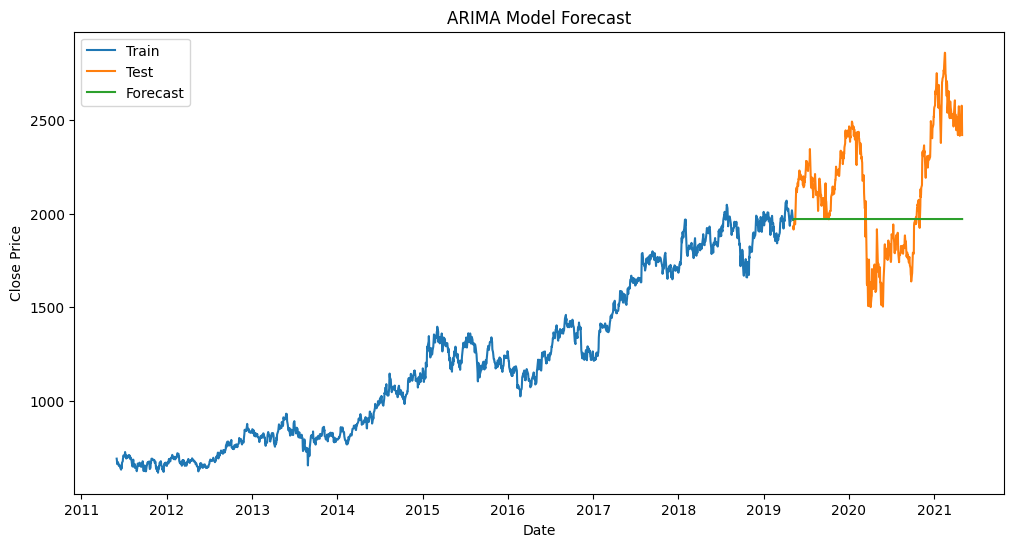

ARIMA RMSE: 357.68


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Prepare the data
series = data['Close']
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Fit ARIMA model (you can choose p,d,q manually or use AIC/BIC to test different combinations)
model = ARIMA(train, order=(5, 1, 0))  # example order, you can tune this
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecasting
forecast = model_fit.forecast(steps=len(test))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# RMSE
A_rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'ARIMA RMSE: {A_rmse:.2f}')


SARIMA MODEL

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1964
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8554.531
Date:                            Sat, 19 Jul 2025   AIC                          17119.062
Time:                                    07:19:16   BIC                          17146.943
Sample:                                         0   HQIC                         17129.312
                                           - 1964                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9361      0.022     43.089      0.000       0.894       0.979
ma.L1         -0.9660      0.017   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


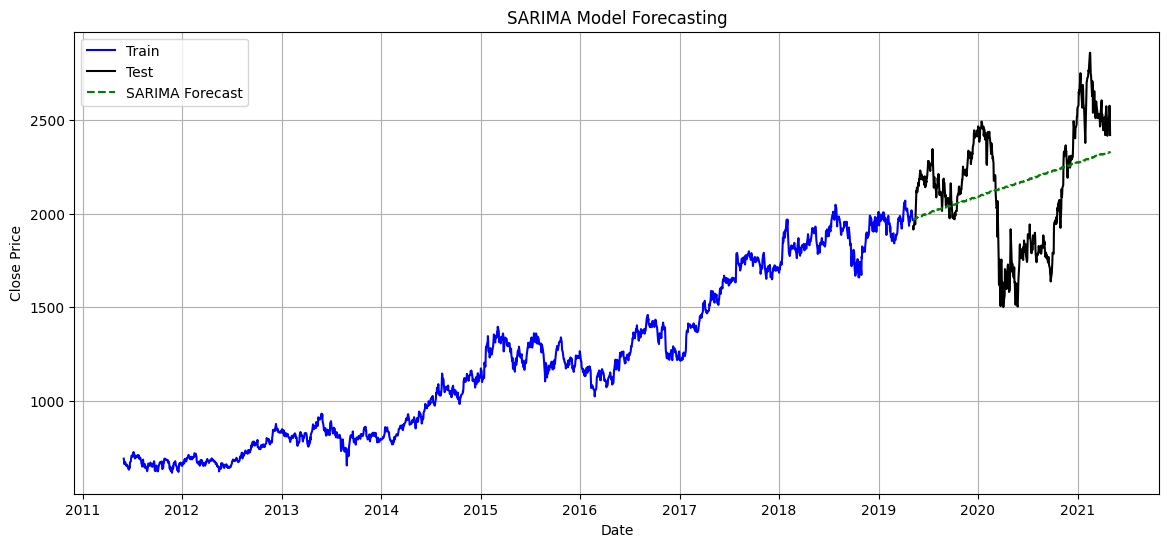

SARIMA RMSE: 305.83


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Load your time series data (ensure datetime index)
# Example:
# data = pd.read_csv("your_file.csv", parse_dates=["Date"], index_col="Date")


series = data['Close']  # Assuming 'data' has a 'Close' column

# Split into train and test sets
train_size = int(len(series) * 0.8)
train = series[:train_size]
test = series[train_size:]

# Fit SARIMA model
# seasonal_order = (P,D,Q,m): m = seasonal period (e.g., 12 for monthly, 252 for daily trading data)
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = model_sarima.fit(disp=False)

# Print model summary
print(sarima_fit.summary())

# Forecast
sarima_pred = sarima_fit.forecast(steps=len(test))

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(test.index, sarima_pred, label='SARIMA Forecast', color='green', linestyle='--')
plt.title('SARIMA Model Forecasting')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(test, sarima_pred))
print(f'SARIMA RMSE: {rmse:.2f}')


LSTM MODEL

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0185
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 3.5018e-04
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 3.3880e-04
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 3.2295e-04
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 3.1671e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 3.1344e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 2.9790e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 2.7556e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 3.0502e-04
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 3.1067e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
LSTM RMSE: 104.31615270180433


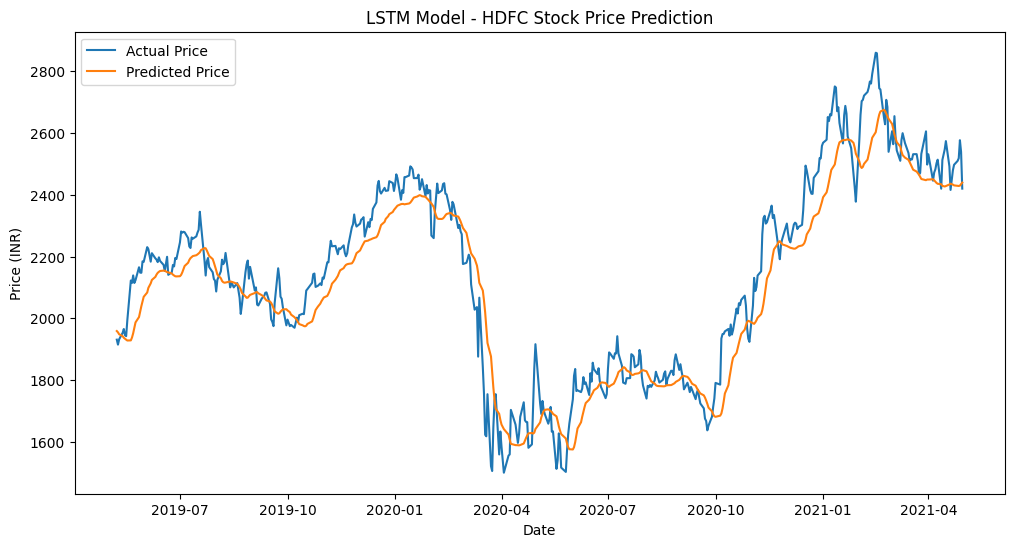

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare 'Close' Price Data
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error
lstm_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'LSTM RMSE: {lstm_rmse}')

prediction_dates = data.index[-len(predictions):]

plt.figure(figsize=(12,6))
plt.plot(prediction_dates, y_test, label='Actual Price')
plt.plot(prediction_dates, predictions, label='Predicted Price')
plt.title('LSTM Model - HDFC Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()


COMPARISON OF ALL 3 MODELS

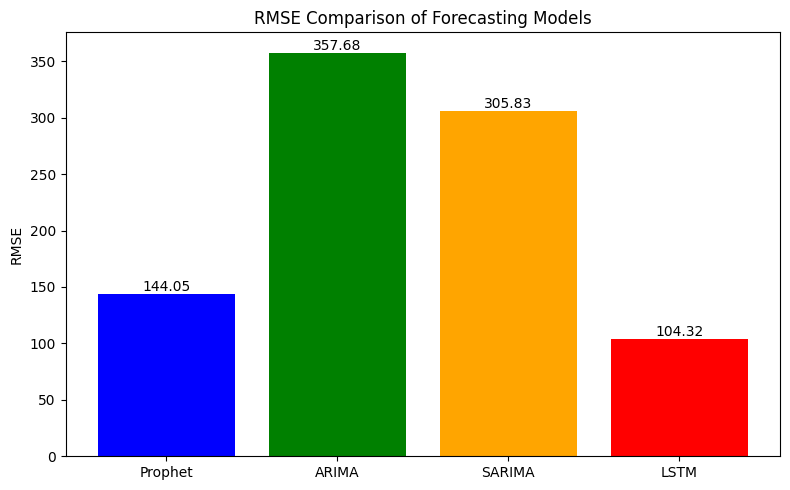

In [27]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already calculated these RMSEs in earlier cells
rmse_prophet = prophet_rmse
rmse_arima = A_rmse
rmse_sarima = rmse
rmse_LSTM = lstm_rmse

# Compare RMSEs
model_names = ['Prophet', 'ARIMA', 'SARIMA', 'LSTM']
rmse_values = [rmse_prophet, rmse_arima, rmse_sarima, rmse_LSTM]

# Plotting RMSE comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, rmse_values, color=['blue', 'green', 'orange', 'red'])
plt.title('RMSE Comparison of Forecasting Models')
plt.ylabel('RMSE')

# Annotate the values on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
